# Lorenz system

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from __future__ import division
from numpy.linalg import qr
%matplotlib notebook

In [2]:
## Lorenz System
def Lorenz(X,a=10,b=28,c=8/3):
    dX = np.ndarray(X.shape)
    dX[0] = a*(X[1]-X[0])
    dX[1] = X[0]*(b-X[2])-X[1] 
    dX[2] = X[0]*X[1]-c*X[2]
    return dX

# Lorenz Jacobian
def J_Lo(X,a=10,b=28,c=8/3):
    return np.array([[-a, a, 0 ], [b-X[2],-1,-X[0]], [X[1],X[0],-c]])

In [106]:
# integrate trajectory and compute first k Lyap Exponents

# params
num_steps = 100000
dt = 0.001
k = 3 # number of LEs to compute
x0 = np.array([-10,-10,20])
Y0 = np.eye(3)

# containers
x_traj = np.empty([num_steps,3])
x_traj[0,:] = x0
running_logs = np.zeros([k,num_steps-1])

# integration
n=0
Q = Y0[:,:k]
while n<num_steps-1:
    n+=1
    x_traj[n,:] = x_traj[n-1,:]+dt*Lorenz(x_traj[n-1]) # integrate solution
    Z = Q+dt*np.matmul(J_Lo(x_traj[n-1,:]),Q)
    Q,R = qr(Z)
    running_logs[:,n-1] = np.log(abs(np.diag(R)))

<IPython.core.display.Javascript object>


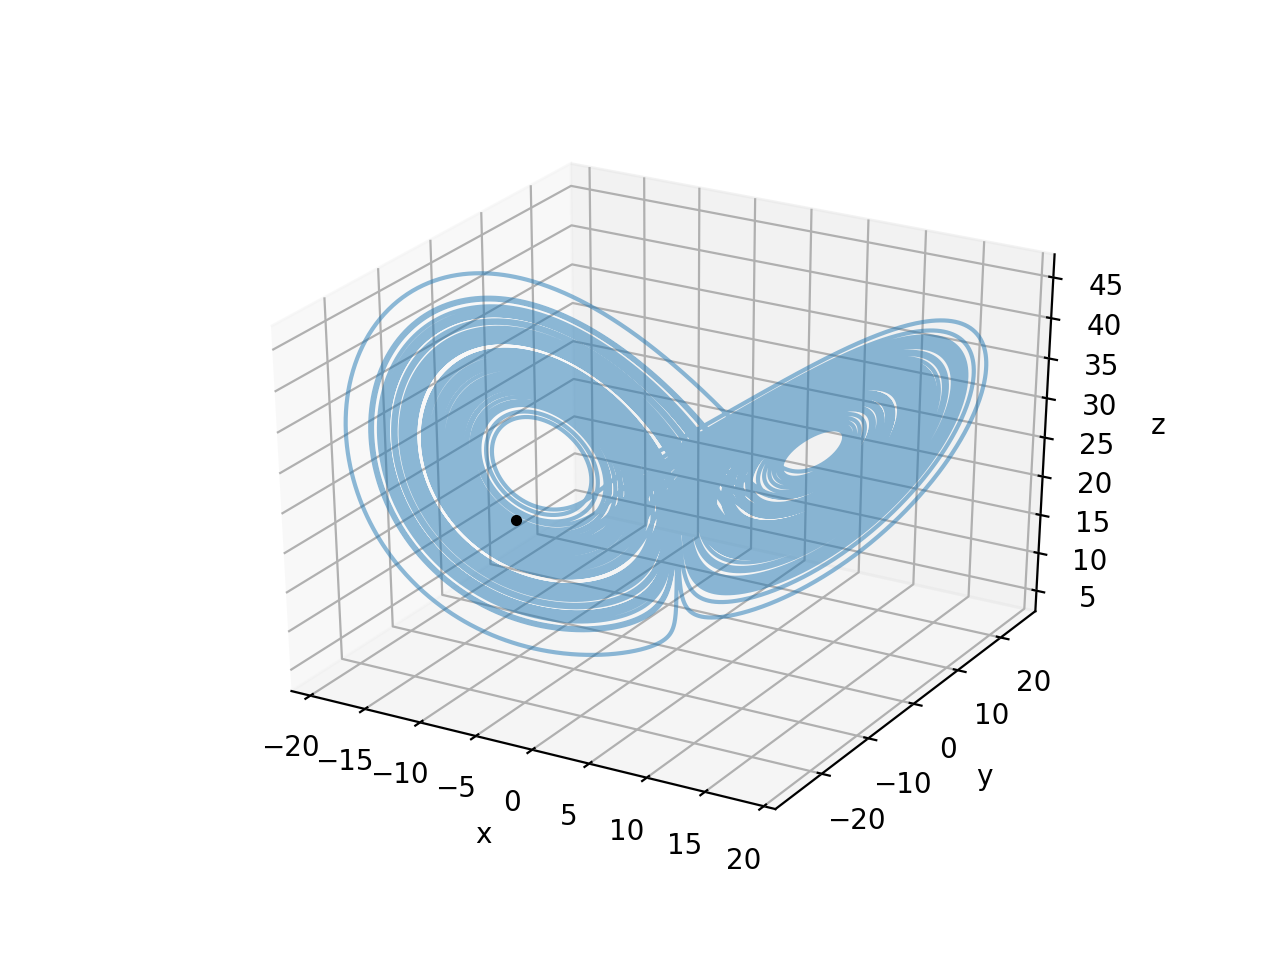

<IPython.core.display.Javascript object>


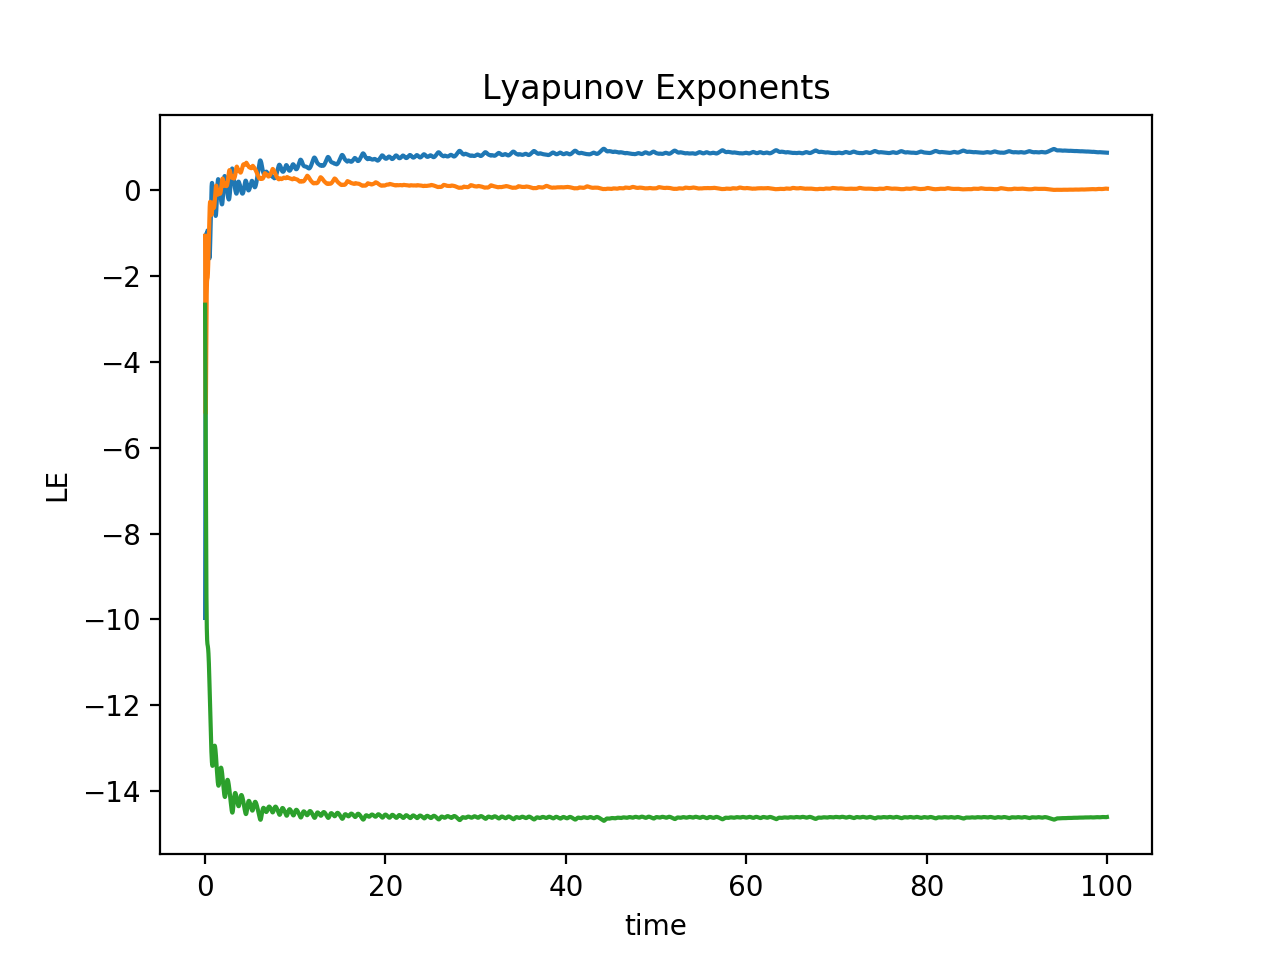

Text(0.5,1,'Lyapunov Exponents')

In [131]:
# plots

# trajectory
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot3D(x_traj[:,0], x_traj[:,1],x_traj[:,2],alpha=0.5)
ax.plot3D(x_traj[:1,0], x_traj[:1,1],x_traj[:1,2],'k.')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

# LE convergence traces
running_div = np.array([n*dt for n in range(1,num_steps)])
plt.figure();
for i in range(k):
    plt.plot(running_div,np.cumsum(running_logs[i,:])/running_div)
plt.xlabel('time');
plt.ylabel('LE');
plt.title('Lyapunov Exponents')

In [130]:
# Check computation
LE_spectrum = running_logs.sum(axis=1)/(num_steps*dt)
print('Lyapunov exponents: %.3f, %.3f, %.3f' %(LE_spectrum[0],LE_spectrum[1],LE_spectrum[2]))
print('Sum of LEs: %.3f, mean det|J|: %.3f' %(LE_spectrum.sum(), np.trace(J_Lo(x0))))


Lyapunov exponents: 0.871, 0.032, -14.604
Sum of LEs: -13.701, mean det|J|: -13.667
